# Rossmann Challenge

## 0. Entorno de ejecución
* pip install pandas
* pip install pandas_summary
* pip install isoweek
* pip install matplotlib
* pip install pyarrow

In [100]:
import numpy as np
import pandas as pd
from pandas_summary import DataFrameSummary
import datetime
from isoweek import Week
from matplotlib import pyplot as plt

## 1. Visualización de los datos

### Descripción de los datos


* **Id** - an Id that represents a (Store, Date) duple within the test set
* **Store** - a unique Id for each store
* **Sales** - the turnover for any given day (this is what you are predicting)
* **Customers** - the number of customers on a given day
* **Open** - an indicator for whether the store was open: 0 = closed, 1 = open
* **StateHoliday** - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* **SchoolHoliday** - indicates if the (Store, Date) was affected by the closure of public schools
* **StoreType** - differentiates between 4 different store models: a, b, c, d
* **Assortment** - describes an assortment level: a = basic, b = extra, c = extended
* **CompetitionDistance** - distance in meters to the nearest competitor store
* **CompetitionOpenSince[Month/Year]** - gives the approximate year and month of the time the nearest competitor was opened
* **Promo** - indicates whether a store is running a promo on that day
* **Promo2** - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* **Promo2Since[Year/Week]** - describes the year and calendar week when the store started participating in Promo2
* **PromoInterval** - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store.

### Importamos los datos

In [2]:
PATH = 'rossmann/'

In [3]:
table_names = ['train', 'test', 'store', 'store_states', 'state_names', 'googletrend', 'weather']
train, test, store, store_states, state_names, googletrend, weather = [pd.read_csv(PATH + fname+'.csv', 
                                                                             low_memory=False) for fname in table_names]

In [4]:
display(train.head())
display(DataFrameSummary(train).summary())

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
count,1017209.0,1017209.0,NaN,1017209.0,1017209.0,1017209.0,1017209.0,NaN,1017209.0
mean,558.429727,3.998341,NaN,5773.818972,633.145946,0.830107,0.381515,NaN,0.178647
std,321.908651,1.997391,NaN,3849.926175,464.411734,0.375539,0.485759,NaN,0.383056
min,1.0,1.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0
25%,280.0,2.0,NaN,3727.0,405.0,1.0,0.0,NaN,0.0
50%,558.0,4.0,NaN,5744.0,609.0,1.0,0.0,NaN,0.0
75%,838.0,6.0,NaN,7856.0,837.0,1.0,1.0,NaN,0.0
max,1115.0,7.0,NaN,41551.0,7388.0,1.0,1.0,NaN,1.0
counts,1017209,1017209,1017209,1017209,1017209,1017209,1017209,1017209,1017209
uniques,1115,7,942,21734,4086,2,2,4,2


In [5]:
train['StateHoliday'].value_counts()

0    986159
a     20260
b      6690
c      4100
Name: StateHoliday, dtype: int64

In [6]:
display(test.head())
display(DataFrameSummary(test).summary())

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
count,41088.0,41088.0,41088.0,NaN,41077.0,41088.0,NaN,41088.0
mean,20544.5,555.899533,3.979167,NaN,0.854322,0.395833,NaN,0.443487
std,11861.228267,320.274496,2.015481,NaN,0.352787,0.489035,NaN,0.496802
min,1.0,1.0,1.0,NaN,0.0,0.0,NaN,0.0
25%,10272.75,279.75,2.0,NaN,1.0,0.0,NaN,0.0
50%,20544.5,553.5,4.0,NaN,1.0,0.0,NaN,0.0
75%,30816.25,832.25,6.0,NaN,1.0,1.0,NaN,1.0
max,41088.0,1115.0,7.0,NaN,1.0,1.0,NaN,1.0
counts,41088,41088,41088,41088,41077,41088,41088,41088
uniques,41088,856,7,48,2,2,2,2


Hay datos faltantes en Open.

In [7]:
display(store.head())
display(DataFrameSummary(store).summary())

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
count,1115.0,NaN,NaN,1112.0,761.0,761.0,1115.0,571.0,571.0,NaN
mean,558.0,NaN,NaN,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573,NaN
std,322.01708,NaN,NaN,7663.17472,3.212348,6.195983,0.500078,14.141984,1.674935,NaN
min,1.0,NaN,NaN,20.0,1.0,1900.0,0.0,1.0,2009.0,NaN
25%,279.5,NaN,NaN,717.5,4.0,2006.0,0.0,13.0,2011.0,NaN
50%,558.0,NaN,NaN,2325.0,8.0,2010.0,1.0,22.0,2012.0,NaN
75%,836.5,NaN,NaN,6882.5,10.0,2013.0,1.0,37.0,2013.0,NaN
max,1115.0,NaN,NaN,75860.0,12.0,2015.0,1.0,50.0,2015.0,NaN
counts,1115,1115,1115,1112,761,761,1115,571,571,571
uniques,1115,4,3,654,12,23,2,24,7,3


Hay datos faltantes en: 
* CompetitionDistance
* CompetitionOpenSinceMonth
* CompetitionOpenSinceYear
* Promo2SinceWeek
* Promo2SinceYear
* PromoInterval

In [8]:
store['StoreType'].value_counts()

a    602
d    348
c    148
b     17
Name: StoreType, dtype: int64

Hay cuatro tipos de tiendas diferentes. La más frecuente es la 'a' y la menos frecuente es la 'b'.

In [9]:
store['PromoInterval'].value_counts()

Jan,Apr,Jul,Oct     335
Feb,May,Aug,Nov     130
Mar,Jun,Sept,Dec    106
Name: PromoInterval, dtype: int64

In [10]:
display(store_states.head(20))
display(DataFrameSummary(store_states).summary())

,Store,State
0,1,HE
1,2,TH
2,3,NW
3,4,BE
4,5,SN
5,6,SN
6,7,SH
7,8,SH
8,9,NW
9,10,"HB,NI"


,Store,State
count,1115.0,NaN
mean,558.0,NaN
std,322.01708,NaN
min,1.0,NaN
25%,279.5,NaN
50%,558.0,NaN
75%,836.5,NaN
max,1115.0,NaN
counts,1115,1115
uniques,1115,12


In [11]:
display(state_names.head(20))
display(DataFrameSummary(state_names).summary())

,StateName,State
0,BadenWuerttemberg,BW
1,Bayern,BY
2,Berlin,BE
3,Brandenburg,BB
4,Bremen,HB
5,Hamburg,HH
6,Hessen,HE
7,MecklenburgVorpommern,MV
8,Niedersachsen,"HB,NI"
9,NordrheinWestfalen,NW


,StateName,State
count,16,16
unique,16,16
top,BadenWuerttemberg,BW
freq,1,1
counts,16,16
uniques,16,16
missing,0,0
missing_perc,0%,0%
types,unique,unique


In [12]:
display(googletrend)
display(DataFrameSummary(googletrend).summary())

,file,week,trend
0,Rossmann_DE_SN,2012-12-02 - 2012-12-08,96
1,Rossmann_DE_SN,2012-12-09 - 2012-12-15,95
2,Rossmann_DE_SN,2012-12-16 - 2012-12-22,91
3,Rossmann_DE_SN,2012-12-23 - 2012-12-29,48
4,Rossmann_DE_SN,2012-12-30 - 2013-01-05,67
...,...,...,...
2067,Rossmann_DE_SL,2015-08-30 - 2015-09-05,95
2068,Rossmann_DE_SL,2015-09-06 - 2015-09-12,47
2069,Rossmann_DE_SL,2015-09-13 - 2015-09-19,80
2070,Rossmann_DE_SL,2015-09-20 - 2015-09-26,57


,file,week,trend
count,NaN,NaN,2072.0
mean,NaN,NaN,63.814189
std,NaN,NaN,12.650246
min,NaN,NaN,0.0
25%,NaN,NaN,55.0
50%,NaN,NaN,64.0
75%,NaN,NaN,72.0
max,NaN,NaN,100.0
counts,2072,2072,2072
uniques,14,148,68


Google Trend: términos de búsqueda más populares del pasado reciente

In [13]:
display(weather)
display(DataFrameSummary(weather[['Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'Precipitationmm']]).summary())

,file,Date,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,...,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees
0,NordrheinWestfalen,2013-01-01,8,4,2,7,5,1,94,87,...,31.0,12.0,4.0,39,26,58.0,5.08,6.0,Rain,215
1,NordrheinWestfalen,2013-01-02,7,4,1,5,3,2,93,85,...,31.0,14.0,10.0,24,16,NaN,0.00,6.0,Rain,225
2,NordrheinWestfalen,2013-01-03,11,8,6,10,8,4,100,93,...,31.0,8.0,2.0,26,21,NaN,1.02,7.0,Rain,240
3,NordrheinWestfalen,2013-01-04,9,9,8,9,9,8,100,94,...,11.0,5.0,2.0,23,14,NaN,0.25,7.0,Rain,263
4,NordrheinWestfalen,2013-01-05,8,8,7,8,7,6,100,94,...,10.0,6.0,3.0,16,10,NaN,0.00,7.0,Rain,268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15835,Saarland,2015-09-13,21,17,12,16,14,12,100,88,...,31.0,15.0,10.0,27,10,50.0,1.02,7.0,Rain,113
15836,Saarland,2015-09-14,18,14,11,15,12,7,99,85,...,31.0,13.0,4.0,32,16,53.0,9.91,5.0,Rain-Thunderstorm,213
15837,Saarland,2015-09-15,16,12,9,11,8,7,93,77,...,31.0,12.0,10.0,34,14,NaN,0.00,5.0,Rain,193
15838,Saarland,2015-09-16,19,15,11,16,13,10,97,90,...,31.0,10.0,4.0,32,14,45.0,20.07,7.0,Rain-Thunderstorm,147


,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Max_Humidity,Mean_Humidity,Min_Humidity,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,CloudCover,Precipitationmm
count,15840.0,15840.0,15840.0,15840.0,15840.0,15840.0,15840.0,15840.0,14667.0,15840.0
mean,14.644129,10.388952,6.19899,93.659596,74.282891,50.158586,22.766604,11.972222,5.551306,0.831718
std,8.646012,7.37926,6.526391,7.67853,13.486552,19.960216,8.988618,5.872844,1.68771,2.513506
min,-11.0,-13.0,-15.0,44.0,30.0,4.0,3.0,2.0,0.0,0.0
25%,8.0,4.0,1.0,90.75,65.0,34.0,16.0,8.0,5.0,0.0
50%,15.0,11.0,7.0,94.0,76.0,49.0,21.0,11.0,6.0,0.0
75%,21.0,16.0,11.0,100.0,85.0,66.0,27.0,14.0,7.0,0.25
max,39.0,31.0,24.0,100.0,100.0,100.0,101.0,53.0,8.0,58.93
counts,15840,15840,15840,15840,15840,15840,15840,15840,14667,15840
uniques,51,45,40,53,71,93,44,29,9,41


In [14]:
weather.isnull().sum()

file                              0
Date                              0
Max_TemperatureC                  0
Mean_TemperatureC                 0
Min_TemperatureC                  0
Dew_PointC                        0
MeanDew_PointC                    0
Min_DewpointC                     0
Max_Humidity                      0
Mean_Humidity                     0
Min_Humidity                      0
Max_Sea_Level_PressurehPa         0
Mean_Sea_Level_PressurehPa        0
Min_Sea_Level_PressurehPa         0
Max_VisibilityKm                381
Mean_VisibilityKm               381
Min_VisibilitykM                381
Max_Wind_SpeedKm_h                0
Mean_Wind_SpeedKm_h               0
Max_Gust_SpeedKm_h            12236
Precipitationmm                   0
CloudCover                     1173
Events                         3951
WindDirDegrees                    0
dtype: int64

Hay datos faltantes en:
* Max_VisibilityKm
* Mean_VisibilityKm
* Min_VisibilitykM
* Max_Gust_SpeedKm_h
* CloudCover
* Events

## 2. Preprocesamiento de los datos

### Tratamiento de datos faltantes

Completamos los datos faltantes en test (columna Open). Consideramos que está abierto si no es día 7.

In [15]:
# Si no es dia 7 esta abierto - Verificado que el store 622 esta usualmente cerrado el día 7
test.loc[test['Open'].isna(), 'Open'] = (test[test['Open'].isna()]['DayOfWeek'] != 7)*1.0

En la tabla de store en la columna de CompetitionOpenSince, tanto para los datos faltantes como para las fechas muy antiguas, ponemos año 1990 y mes 1.

In [16]:
# Fechas de las mas antiguas segun datos y tambien las fechas anteriores las pongo como minimo en 1990
store.loc[store['CompetitionOpenSinceYear'].isna() | (store['CompetitionOpenSinceYear']<1990), 'CompetitionOpenSinceYear'] = np.int32(1990)
store.loc[store['CompetitionOpenSinceMonth'].isna() | (store['CompetitionOpenSinceYear']<1990), 'CompetitionOpenSinceMonth'] = np.int32(1)

En store, columna CompetitionDistance, completamos los datos faltantes con la distancia máxima, considerando que están lejos.

In [17]:
# Si no tengo la distancia, supongo que no hay (Como si estuviera lejos)
print(store['CompetitionDistance'].max(), store['CompetitionDistance'].mean(), store['CompetitionDistance'].min())
store.loc[store['CompetitionDistance'].isna(), 'CompetitionDistance'] = store['CompetitionDistance'].max()

75860.0 5404.901079136691 20.0


In [18]:
store.loc[store['Promo2'] == 0,'Promo2':'PromoInterval'].count()

Promo2             544
Promo2SinceWeek      0
Promo2SinceYear      0
PromoInterval        0
dtype: int64

In [19]:
store.loc[store['Promo2'] == 1,'Promo2':'PromoInterval'].count()

Promo2             571
Promo2SinceWeek    571
Promo2SinceYear    571
PromoInterval      571
dtype: int64

Vemos que los datos faltantes corresponden a las tiendas en que Promo2 es 0. Consideramos que iniciaron en la semana 0.

In [20]:
# Si no tiene Promo2 entonces la semana en donde empezo es cero. Esto será tratado como categórica por eso tiene sentido
store.loc[store['Promo2SinceWeek'].isna() & (store['Promo2'] == 0), 'Promo2SinceWeek'] = np.int32(1)
store.loc[store['Promo2SinceYear'].isna() & (store['Promo2'] == 0), 'Promo2SinceYear'] = np.int32(1990)
store.loc[store['PromoInterval'].isna() & (store['Promo2'] == 0), 'PromoInterval'] = '-'

Para completar los datos faltantes en weather, consideramos que fueron días tranquilos.

In [21]:
# Supongo que son dias tranquilos (de todas formas no se usaran para la predicción)
weather.loc[weather['Max_VisibilityKm'].isna(), 'Max_VisibilityKm'] = weather['Max_VisibilityKm'].max()
weather.loc[weather['Mean_VisibilityKm'].isna(), 'Mean_VisibilityKm'] = weather['Mean_VisibilityKm'].max()
weather.loc[weather['Min_VisibilitykM'].isna(), 'Min_VisibilitykM'] = weather['Min_VisibilitykM'].max()
weather.loc[weather['Max_Gust_SpeedKm_h'].isna(), 'Max_Gust_SpeedKm_h'] = weather['Max_Gust_SpeedKm_h'].min()
weather.loc[weather['CloudCover'].isna(), 'CloudCover'] = weather['CloudCover'].min()
weather.loc[weather['Events'].isna(), 'Events'] = 'Sunny'

In [22]:
print(test.isnull().sum().sum())
print(store.isnull().sum().sum())
print(weather.isnull().sum().sum())

0
0
0


### Emprolijamos columnas de fechas

Con las columnas de CompetitionSinceYear y CompetitionSinceMonth, y lo mismo para Promo2 generamos una nueva columna en formato fecha.

In [23]:
store['CompetitionOpenSinceYear'] = store['CompetitionOpenSinceYear'].astype(np.int32)
store['CompetitionOpenSinceMonth'] = store['CompetitionOpenSinceMonth'].astype(np.int32)
store['Promo2SinceWeek'] = store['Promo2SinceWeek'].astype(np.int32)
store['Promo2SinceYear'] = store['Promo2SinceYear'].astype(np.int32)

In [24]:
# Creo una nueva columna con fecha de apertura en formato de fecha (dia 15 por que no tengo el dato y no es relevante)
store['CompetitionOpenSince'] = pd.to_datetime(store.apply(lambda x: datetime.datetime(
    x.CompetitionOpenSinceYear, x.CompetitionOpenSinceMonth, 15), axis=1))

Creamos otra columna de Promo2Since con el año y la semana, en formato datetime.

In [25]:
store["Promo2Since"] = pd.to_datetime(store.apply(lambda x: Week(
    x.Promo2SinceYear, x.Promo2SinceWeek).monday(), axis=1))

## 3. Join entre tablas

### Función join

In [26]:
def join_df(left, right, left_on, right_on=None):
    if right_on is None: right_on = left_on
    return left.merge(right, how='left', left_on=left_on, right_on=right_on, 
                      suffixes=("", "_y"))

### Join entre tabla weather y state_names

Las columnas para hacer el join son weather['file'] y state_names['StateName']

In [27]:
weather.file.value_counts()

NordrheinWestfalen       990
Niedersachsen            990
Bayern                   990
Bremen                   990
Brandenburg              990
SachsenAnhalt            990
Sachsen                  990
Hessen                   990
MecklenburgVorpommern    990
RheinlandPfalz           990
BadenWuerttemberg        990
Berlin                   990
Hamburg                  990
SchleswigHolstein        990
Thueringen               990
Saarland                 990
Name: file, dtype: int64

In [28]:
state_names.StateName.value_counts()

BadenWuerttemberg        1
Bayern                   1
Berlin                   1
Brandenburg              1
Bremen                   1
Hamburg                  1
Hessen                   1
MecklenburgVorpommern    1
Niedersachsen            1
NordrheinWestfalen       1
RheinlandPfalz           1
Saarland                 1
Sachsen                  1
SachsenAnhalt            1
SchleswigHolstein        1
Thueringen               1
Name: StateName, dtype: int64

Columnas de weather antes del join:

In [29]:
weather.columns

Index(['file', 'Date', 'Max_TemperatureC', 'Mean_TemperatureC',
       'Min_TemperatureC', 'Dew_PointC', 'MeanDew_PointC', 'Min_DewpointC',
       'Max_Humidity', 'Mean_Humidity', 'Min_Humidity',
       'Max_Sea_Level_PressurehPa', 'Mean_Sea_Level_PressurehPa',
       'Min_Sea_Level_PressurehPa', 'Max_VisibilityKm', 'Mean_VisibilityKm',
       'Min_VisibilitykM', 'Max_Wind_SpeedKm_h', 'Mean_Wind_SpeedKm_h',
       'Max_Gust_SpeedKm_h', 'Precipitationmm', 'CloudCover', 'Events',
       'WindDirDegrees'],
      dtype='object')

Columnas de state_names

In [30]:
state_names.columns

Index(['StateName', 'State'], dtype='object')

In [31]:
weather = join_df(weather, state_names, "file", "StateName")

Columnas en weather luego del join:

In [32]:
weather.columns

Index(['file', 'Date', 'Max_TemperatureC', 'Mean_TemperatureC',
       'Min_TemperatureC', 'Dew_PointC', 'MeanDew_PointC', 'Min_DewpointC',
       'Max_Humidity', 'Mean_Humidity', 'Min_Humidity',
       'Max_Sea_Level_PressurehPa', 'Mean_Sea_Level_PressurehPa',
       'Min_Sea_Level_PressurehPa', 'Max_VisibilityKm', 'Mean_VisibilityKm',
       'Min_VisibilitykM', 'Max_Wind_SpeedKm_h', 'Mean_Wind_SpeedKm_h',
       'Max_Gust_SpeedKm_h', 'Precipitationmm', 'CloudCover', 'Events',
       'WindDirDegrees', 'StateName', 'State'],
      dtype='object')

Vemos que se agregaron a la derecha StateName y State.

## 4.0 Preprocesamiento de googletrend (datos externos)

In [33]:
googletrend.head()

,file,week,trend
0,Rossmann_DE_SN,2012-12-02 - 2012-12-08,96
1,Rossmann_DE_SN,2012-12-09 - 2012-12-15,95
2,Rossmann_DE_SN,2012-12-16 - 2012-12-22,91
3,Rossmann_DE_SN,2012-12-23 - 2012-12-29,48
4,Rossmann_DE_SN,2012-12-30 - 2013-01-05,67


Creo una nueva columna Date y me quedo con la primera fecha de week. 

In [34]:
# Armo columan date con el primer día de la secmana
googletrend['Date'] = googletrend.week.str.split(' - ', expand=True)[0]

In [35]:
googletrend.head()

,file,week,trend,Date
0,Rossmann_DE_SN,2012-12-02 - 2012-12-08,96,2012-12-02
1,Rossmann_DE_SN,2012-12-09 - 2012-12-15,95,2012-12-09
2,Rossmann_DE_SN,2012-12-16 - 2012-12-22,91,2012-12-16
3,Rossmann_DE_SN,2012-12-23 - 2012-12-29,48,2012-12-23
4,Rossmann_DE_SN,2012-12-30 - 2013-01-05,67,2012-12-30


Genera una columna State con el estado a partir del código de la columna file

In [36]:
# Armo columna de State con el nomnre del estado
googletrend['State'] = googletrend.file.str.split('_', expand=True)[2]

In [37]:
googletrend.head()

,file,week,trend,Date,State
0,Rossmann_DE_SN,2012-12-02 - 2012-12-08,96,2012-12-02,SN
1,Rossmann_DE_SN,2012-12-09 - 2012-12-15,95,2012-12-09,SN
2,Rossmann_DE_SN,2012-12-16 - 2012-12-22,91,2012-12-16,SN
3,Rossmann_DE_SN,2012-12-23 - 2012-12-29,48,2012-12-23,SN
4,Rossmann_DE_SN,2012-12-30 - 2013-01-05,67,2012-12-30,SN


In [38]:
googletrend['State'].value_counts()

SN    148
BY    148
TH    148
NW    148
BE    148
RP    148
BW    148
NI    148
SH    148
HE    148
ST    148
HH    148
SL    148
Name: State, dtype: int64

In [39]:
# Notar que un estado tiene un acrónimo diferente
state_names['State']

0        BW
1        BY
2        BE
3        BB
4        HB
5        HH
6        HE
7        MV
8     HB,NI
9        NW
10       RP
11       SL
12       SN
13       ST
14       SH
15       TH
Name: State, dtype: object

Como el estado HB,NI tiene un acrónimo distinto en la tabla de googletrend, lo corregimos.

In [40]:
# Lo corrijo
googletrend.loc[googletrend.State=='NI', "State"] = 'HB,NI'

## 5. Transformación de fechas

A partir de la columna Date, creamos 4 columnas nuevas para el año (Year), el mes (Month), la semana (Week) y el día (Day). Aplicamos esto a todas las tablas.

In [41]:
def add_datepart(df):
    df.Date = pd.to_datetime(df.Date)
    df["Year"] = df.Date.dt.year
    df["Month"] = df.Date.dt.month
    df["Week"] = df.Date.dt.isocalendar().week
    df["Day"] = df.Date.dt.day
    
add_datepart(weather)
add_datepart(googletrend)
add_datepart(train)
add_datepart(test)

Notamos que las tendencias generales de Alemania no tienen el estado al final del código en la columna file. Por ende, las guardamos en una tabla parte (trend_de).

In [42]:
# Trends generales de alemania tienen el state en None
trend_de = googletrend[googletrend.file == 'Rossmann_DE']

In [43]:
trend_de[['Date', 'Year','Month','Week','Day']]

,Date,Year,Month,Week,Day
148,2012-12-02,2012,12,48,2
149,2012-12-09,2012,12,49,9
150,2012-12-16,2012,12,50,16
151,2012-12-23,2012,12,51,23
152,2012-12-30,2012,12,52,30
...,...,...,...,...,...
291,2015-08-30,2015,8,35,30
292,2015-09-06,2015,9,36,6
293,2015-09-13,2015,9,37,13
294,2015-09-20,2015,9,38,20


## 6. Realizamos el resto de los joins

En la tabla store agregamos el acrónimos de los estados usando store_states (on "Store")

In [44]:
# Agrego acronimo de state al store
store = join_df(store, store_states, "Store")
len(store[store.State.isnull()])

0

In [45]:
store.columns

Index(['Store', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval',
       'CompetitionOpenSince', 'Promo2Since', 'State'],
      dtype='object')

Vemos que se agregó al final la columna State.

Hacemos el join entre train y store utilizando la columna "Store"

In [46]:
# Mergeo train y store
joined_train = join_df(train, store, "Store")
len(joined_train[joined_train.StoreType.isnull()])

0

Realizamos lo mismo para test

In [47]:
# Mergeo test y store
joined_test = join_df(test, store, "Store")
len(joined_test[joined_test.StoreType.isnull()])

0

Ahora agregamos la información de la tabla googletrend teniendo en cuenta el estado, el año y la semana. Lo hacemos para train y para test

In [48]:
# Mergeo con googletrend
joined_train = join_df(joined_train, googletrend, ["State","Year", "Week"])
len(joined_train[joined_train.trend.isnull()])

0

In [49]:
joined_test = join_df(joined_test, googletrend, ["State","Year", "Week"])
len(joined_test[joined_test.trend.isnull()])

0

Hacemos join con las tendencias generales de Alemania, tanto para train como para test. La columna de tendencia general se agrega con el nombre 'trend_DE' para diferenciarla de la de tendencia local 'trend'.

In [50]:
joined_train = joined_train.merge(trend_de, 'left', ["Year", "Week"], suffixes=('', '_DE'))
len(joined_train[joined_train.trend_DE.isnull()])

0

In [51]:
joined_train.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'Year', 'Month', 'Week', 'Day',
       'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval',
       'CompetitionOpenSince', 'Promo2Since', 'State', 'file', 'week', 'trend',
       'Date_y', 'Month_y', 'Day_y', 'file_DE', 'week_DE', 'trend_DE',
       'Date_DE', 'State_DE', 'Month_DE', 'Day_DE'],
      dtype='object')

In [52]:
joined_test = joined_test.merge(trend_de, 'left', ["Year", "Week"], suffixes=('', '_DE'))
len(joined_test[joined_test.trend_DE.isnull()])

0

Hacemos join de train con la tabla de weather, según el estado y la fecha. Luego repetimos para test.

In [53]:
joined_train = join_df(joined_train, weather, ["State","Date"])
len(joined_train[joined_train.Mean_TemperatureC.isnull()])

0

In [54]:
joined_test = join_df(joined_test, weather, ["State","Date"])
len(joined_test[joined_test.Mean_TemperatureC.isnull()])

0

Luego de los joins el dataset de train queda con las siguientes columnas:

In [55]:
joined_train.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'Year', 'Month', 'Week', 'Day',
       'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval',
       'CompetitionOpenSince', 'Promo2Since', 'State', 'file', 'week', 'trend',
       'Date_y', 'Month_y', 'Day_y', 'file_DE', 'week_DE', 'trend_DE',
       'Date_DE', 'State_DE', 'Month_DE', 'Day_DE', 'file_y',
       'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
       'Dew_PointC', 'MeanDew_PointC', 'Min_DewpointC', 'Max_Humidity',
       'Mean_Humidity', 'Min_Humidity', 'Max_Sea_Level_PressurehPa',
       'Mean_Sea_Level_PressurehPa', 'Min_Sea_Level_PressurehPa',
       'Max_VisibilityKm', 'Mean_VisibilityKm', 'Min_VisibilitykM',
       'Max_Wind_SpeedKm_h', 'Mean_Wind_SpeedKm_h', 'Max_Gust_SpeedKm_h',
       'Precipitationmm', 'Cl

## 7. Trabajamos con las fechas

###  CompetitionOpenSince en días guardada en CompetitionDaysOpen

Creamos una columna CompetitionDaysOpen con la cantidad de días que pasaron desde que abrió la competencia.

In [56]:
joined_train["CompetitionDaysOpen"] = joined_train.Date.subtract(joined_train["CompetitionOpenSince"]).dt.days
joined_train["CompetitionDaysOpen"][:10]

0    2510
1    2815
2    3150
3    2145
4     107
5     593
6     837
7     289
8    5463
9    2145
Name: CompetitionDaysOpen, dtype: int64

Repetimos para test:

In [57]:
joined_test["CompetitionDaysOpen"] = joined_test.Date.subtract(joined_test["CompetitionOpenSince"]).dt.days
joined_test["CompetitionDaysOpen"][:10]

0    2558
1    3198
2     885
3     337
4    5511
5    2193
6    1402
7    9376
8    9376
9     551
Name: CompetitionDaysOpen, dtype: int64

Dado que se consideró como fecha mínima enero de 1990, hay que corregir el cálculo de los días. Ponemos 0 donde sea negativo.

In [58]:
# Corrige errores de la formula anterior
joined_train.loc[joined_train.CompetitionDaysOpen<0, "CompetitionDaysOpen"] = 0

In [59]:
# Corrige errores de la formula anterior
joined_test.loc[joined_test.CompetitionDaysOpen<0, "CompetitionDaysOpen"] = 0

Creamos una columna CompetitionMonthsOpen con esta información en meses. Además, limitamos este valor como máximo a 24 meses.

In [60]:
# Lo pone en meses y limita a 2 años como máximo
joined_train["CompetitionMonthsOpen"] = joined_train["CompetitionDaysOpen"]//30
joined_train.loc[joined_train.CompetitionMonthsOpen>24, "CompetitionMonthsOpen"] = 24
joined_train.CompetitionMonthsOpen.value_counts()

24    790886
0      92590
6       6356
7       6350
4       6278
5       6261
8       6203
9       6138
10      6118
11      5971
12      5867
3       5850
13      5724
15      5699
14      5655
19      5649
2       5621
18      5619
16      5618
22      5558
17      5549
20      5500
1       5482
21      5398
23      5269
Name: CompetitionMonthsOpen, dtype: int64

In [61]:
# Lo pone en meses y limita a 2 años como máximo
joined_test["CompetitionMonthsOpen"] = joined_test["CompetitionDaysOpen"]//30
joined_test.loc[joined_test.CompetitionMonthsOpen>24, "CompetitionMonthsOpen"] = 24
joined_test.CompetitionMonthsOpen.value_counts()

24    36782
23      346
17      292
16      287
13      260
1       257
10      247
11      246
14      197
0       179
18      169
12      164
2       161
8       161
4       152
5       151
20      149
21      148
22      146
3       141
15      126
9       125
19       84
7        60
6        58
Name: CompetitionMonthsOpen, dtype: int64

### Tratamiento de fechas de Promo2

Realizamos el mismo procedimiento para las fechas de Promo2. Luego de calcular los días desde Promo2, creamos una columna con esta información en semanas y la limitamos como máximo a 25.

In [62]:
joined_train["Promo2Days"] = joined_train.Date.subtract(joined_train["Promo2Since"]).dt.days
joined_train.loc[joined_train.Promo2Days<0, "Promo2Days"] = 0
joined_train["Promo2Weeks"] = joined_train["Promo2Days"]//7
joined_train.loc[joined_train.Promo2Weeks<0, "Promo2Weeks"] = 0
joined_train.loc[joined_train.Promo2Weeks>25, "Promo2Weeks"] = 25
joined_train.Promo2Weeks.value_counts()

25    911602
0      70849
14      1659
21      1659
24      1659
16      1659
23      1659
15      1659
19      1659
22      1659
20      1659
18      1652
17      1633
13      1514
7       1267
6       1267
5       1263
8       1261
10      1260
11      1260
12      1260
9       1258
4       1236
3       1232
2       1232
1       1232
Name: Promo2Weeks, dtype: int64

In [63]:
joined_test["Promo2Days"] = joined_test.Date.subtract(joined_test["Promo2Since"]).dt.days
joined_test.loc[joined_test.Promo2Days<0, "Promo2Days"] = 0
joined_test["Promo2Weeks"] = joined_test["Promo2Days"]//7
joined_test.loc[joined_test.Promo2Weeks<0, "Promo2Weeks"] = 0
joined_test.loc[joined_test.Promo2Weeks>25, "Promo2Weeks"] = 25
joined_test.Promo2Weeks.value_counts()

25    40704
19       35
18       35
20       32
23       28
14       28
22       28
21       28
13       23
12       21
11       21
10       21
9        21
15       19
24       16
17       15
16        7
8         6
Name: Promo2Weeks, dtype: int64

### Vemos cómo quedaron los datasets de train y shape

In [64]:
joined_train.shape, joined_test.shape

((1017209, 70), (41088, 69))

Eliminamos columnas con datos duplicados

In [65]:
# Remove dup columns
joined_train = joined_train.loc[:,~joined_train.columns.duplicated()]
joined_test = joined_test.loc[:,~joined_test.columns.duplicated()]

In [66]:
joined_train.shape, joined_test.shape

((1017209, 68), (41088, 67))

In [67]:
set(joined_train.columns) - set(joined_test.columns)

{'Customers', 'Sales'}

Vemos que la información que falta en la tabla de test, y que buscaremos predecir es 'Customers' y 'Sales'

## 8. Tratamiendo de StateHoliday

Vemos las categorías de StateHoliday

In [68]:
joined_train['StateHoliday'].value_counts()

0    986159
a     20260
b      6690
c      4100
Name: StateHoliday, dtype: int64

a = public holiday, b = Easter holiday, c = Christmas, 0 = None

Creamos una columna 'StateHoliday_bool' de tipo booleana que sea True si es Holiday y False si no.

In [69]:
joined_train.loc[:,'StateHoliday_bool'] = joined_train['StateHoliday']!='0'
joined_test.loc[:,'StateHoliday_bool'] = joined_test['StateHoliday']!='0'

In [70]:
joined_test[['StateHoliday','StateHoliday_bool']]


,StateHoliday,StateHoliday_bool
0,0,False
1,0,False
2,0,False
3,0,False
4,0,False
...,...,...
41083,0,False
41084,0,False
41085,0,False
41086,0,False


## 9. Duraciones

#### Tiempo antes y después de un evento

Consideramos eventos a los Holiday y las Promo y vamos a calcular para cada registro, cuanto tiempo transcurrió desde el último evento y cuánto falta para el próximo

In [71]:
columns = ["Date", "Store", "Promo", "StateHoliday_bool", "SchoolHoliday"]

Solo necesitamos estas columnas, por lo que generamos un sub-dataframe para facilitar el procesamiento.

In [72]:
df_train = joined_train[columns]
df_test = joined_test[columns]

In [73]:
df_train.head()

,Date,Store,Promo,StateHoliday_bool,SchoolHoliday
0,2015-07-31,1,1,False,1
1,2015-07-31,2,1,False,1
2,2015-07-31,3,1,False,1
3,2015-07-31,4,1,False,1
4,2015-07-31,5,1,False,1


In [74]:
df_test.head()

,Date,Store,Promo,StateHoliday_bool,SchoolHoliday
0,2015-09-17,1,1,False,0
1,2015-09-17,3,1,False,0
2,2015-09-17,7,1,False,0
3,2015-09-17,8,1,False,0
4,2015-09-17,9,1,False,0


Vamos a generar una clase 'elapsed' que nos va a permitir calcular para cada fila el tiempo que falta para el próximo evento o que transcurrió desde el último.

In [75]:
class elapsed(object):
    def __init__(self, fld): 
        self.fld = fld #entra como argumento el evento que estamos analizando: Promo o Holiday. Lo guardamos en fld
        self.last = pd.to_datetime(np.nan) #en last guardamos la fecha del último evento (o próximo)
        self.last_store = 0 #en last_store guardamos qué store estamos analizando.
        
    def get(self, row):
        if row.Store != self.last_store: #si el último store analizado es distinto del actual, reiniciamos la cuenta.
            self.last = pd.to_datetime(np.nan) #seteamos la última fecha como nan
            self.last_store = row.Store #y asignamos el nuevo Store en last_store
        if (row[self.fld]): self.last = row.Date #ahora vemos si la fila actual es un evento o no y si es, la guardamos en last
        return row.Date-self.last #finalmente devolvemos la diferencia entre la fecha actual y la del último evento

Generamos la función que aplicaremos al dataframe para realizar el cálculo fila por fila. Ingresamos como argumentos:
* el dataframe
* el evento que estamos analizando
* el prefijo con el que vamos a llamar a la nueva columna generada: 'Before' si estamos viendo los días antes de que ocurra el próximo evento, y 'After' si estamos viendo cuántos días transcurrieron desde el últlimo.

In [76]:
def add_elapsed(df, fld, prefix):
    sh_el = elapsed(fld)
    df[prefix+fld] = df.apply(sh_el.get, axis=1)

**SchoolHoliday**

* Días después de un evento SchoolHoliday

Primero ordenamos los datos según Store y Date (en orden ascendente). Luego aplicamos la función add_elapsed que generará la columna AfterSchoolHoliday con los días que pasaron desde el último StateHoliday. Lo hacemos con train y test.

In [77]:
fld = 'SchoolHoliday'
df_train = df_train.sort_values(['Store', 'Date'])
add_elapsed(df_train, fld, 'After')
df_train.head()

,Date,Store,Promo,StateHoliday_bool,SchoolHoliday,AfterSchoolHoliday
1016095,2013-01-01,1,0,True,1,0 days
1014980,2013-01-02,1,0,False,1,0 days
1013865,2013-01-03,1,0,False,1,0 days
1012750,2013-01-04,1,0,False,1,0 days
1011635,2013-01-05,1,0,False,1,0 days


In [78]:
df_test = df_test.sort_values(['Store', 'Date'])
add_elapsed(df_test, fld, 'After')
df_test.head()

,Date,Store,Promo,StateHoliday_bool,SchoolHoliday,AfterSchoolHoliday
40232,2015-08-01,1,0,False,1,0 days
39376,2015-08-02,1,0,False,1,0 days
38520,2015-08-03,1,1,False,1,0 days
37664,2015-08-04,1,1,False,1,0 days
36808,2015-08-05,1,1,False,1,0 days


* Días antes de un evento SchoolHoliday

Realizamos el mismo procedimiento, pero ahora ordenamos las fechas de mayor a menor. Esto nos dará los días antes de un evento (signo negativo)

In [79]:
df_train = df_train.sort_values(['Store', 'Date'], ascending=[True, False])
add_elapsed(df_train, fld, 'Before')
df_train.head()

,Date,Store,Promo,StateHoliday_bool,SchoolHoliday,AfterSchoolHoliday,BeforeSchoolHoliday
0,2015-07-31,1,1,False,1,0 days,0 days
1115,2015-07-30,1,1,False,1,0 days,0 days
2230,2015-07-29,1,1,False,1,0 days,0 days
3345,2015-07-28,1,1,False,1,0 days,0 days
4460,2015-07-27,1,1,False,1,0 days,0 days


In [80]:
df_test = df_test.sort_values(['Store', 'Date'], ascending=[True, False])
add_elapsed(df_test, fld, 'Before')
df_test.head()

,Date,Store,Promo,StateHoliday_bool,SchoolHoliday,AfterSchoolHoliday,BeforeSchoolHoliday
0,2015-09-17,1,1,False,0,13 days,NaT
856,2015-09-16,1,1,False,0,12 days,NaT
1712,2015-09-15,1,1,False,0,11 days,NaT
2568,2015-09-14,1,1,False,0,10 days,NaT
3424,2015-09-13,1,0,False,0,9 days,NaT


NaT: not a time. Esto es porque no hay fechas posteriores con el evento.

**StateHoliday**

* Días después y antes de un evento StateHoliday

In [81]:
fld = 'StateHoliday_bool'
df_train = df_train.sort_values(['Store', 'Date'])
add_elapsed(df_train, fld, 'After')
df_train = df_train.sort_values(['Store', 'Date'], ascending=[True, False])
add_elapsed(df_train, fld, 'Before')

In [82]:
fld = 'StateHoliday_bool'
df_test = df_test.sort_values(['Store', 'Date'])
add_elapsed(df_test, fld, 'After')
df_test = df_test.sort_values(['Store', 'Date'], ascending=[True, False])
add_elapsed(df_test, fld, 'Before')

**Promo**

* Días antes y después de un evento Promo

In [86]:
fld = 'Promo'
df_train = df_train.sort_values(['Store', 'Date'])
add_elapsed(df_train, fld, 'After')
df_train = df_train.sort_values(['Store', 'Date'], ascending=[True, False])
add_elapsed(df_train, fld, 'Before')

In [87]:
fld = 'Promo'
df_test = df_test.sort_values(['Store', 'Date'])
add_elapsed(df_test, fld, 'After')
df_test = df_test.sort_values(['Store', 'Date'], ascending=[True, False])
add_elapsed(df_test, fld, 'Before')

In [88]:
df_train.head(10)

,Date,Store,Promo,StateHoliday_bool,SchoolHoliday,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday_bool,BeforeStateHoliday_bool,AfterPromo,BeforePromo
0,2015-07-31,1,1,False,1,0 days,0 days,57 days,NaT,0 days,0 days
1115,2015-07-30,1,1,False,1,0 days,0 days,56 days,NaT,0 days,0 days
2230,2015-07-29,1,1,False,1,0 days,0 days,55 days,NaT,0 days,0 days
3345,2015-07-28,1,1,False,1,0 days,0 days,54 days,NaT,0 days,0 days
4460,2015-07-27,1,1,False,1,0 days,0 days,53 days,NaT,0 days,0 days
5575,2015-07-26,1,0,False,0,107 days,-1 days,52 days,NaT,9 days,-1 days
6690,2015-07-25,1,0,False,0,106 days,-2 days,51 days,NaT,8 days,-2 days
7805,2015-07-24,1,0,False,0,105 days,-3 days,50 days,NaT,7 days,-3 days
8920,2015-07-23,1,0,False,0,104 days,-4 days,49 days,NaT,6 days,-4 days
10035,2015-07-22,1,0,False,0,103 days,-5 days,48 days,NaT,5 days,-5 days


Seteamos Date como index

In [89]:
df_train = df_train.set_index("Date")
df_test = df_test.set_index("Date")

In [91]:
df_train.sort_values('Date').head()

,Store,Promo,StateHoliday_bool,SchoolHoliday,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday_bool,BeforeStateHoliday_bool,AfterPromo,BeforePromo
Date,,,,,,,,,,
2013-01-01,1115,0,True,1,0 days,0 days,0 days,0 days,NaT,-6 days
2013-01-01,746,0,True,1,0 days,0 days,0 days,0 days,NaT,-6 days
2013-01-01,171,0,True,1,0 days,0 days,0 days,0 days,NaT,-6 days
2013-01-01,694,0,True,1,0 days,0 days,0 days,0 days,NaT,-6 days
2013-01-01,396,0,True,1,0 days,0 days,0 days,0 days,NaT,-6 days


In [92]:
df_test.sort_values('Date').head()

,Store,Promo,StateHoliday_bool,SchoolHoliday,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday_bool,BeforeStateHoliday_bool,AfterPromo,BeforePromo
Date,,,,,,,,,,
2015-08-01,553,0,False,0,NaT,-2 days,NaT,NaT,NaT,-2 days
2015-08-01,394,0,False,1,0 days,0 days,NaT,NaT,NaT,-2 days
2015-08-01,393,0,False,0,NaT,-2 days,NaT,NaT,NaT,-2 days
2015-08-01,392,0,False,0,NaT,-2 days,NaT,NaT,NaT,-2 days
2015-08-01,391,0,False,0,NaT,-2 days,NaT,NaT,NaT,-2 days


### Eliminamos NaT

Completamos con 0.

In [93]:
columns = ['SchoolHoliday', 'StateHoliday_bool', 'Promo']

In [94]:
for o in ['Before', 'After']:
    for p in columns:
        a = o+p
        df_train[a] = df_train[a].fillna(pd.Timedelta(0)).dt.days
        df_test[a] = df_test[a].fillna(pd.Timedelta(0)).dt.days

In [96]:
df_train.sort_values('Date').head(10)

,Store,Promo,StateHoliday_bool,SchoolHoliday,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday_bool,BeforeStateHoliday_bool,AfterPromo,BeforePromo
Date,,,,,,,,,,
2013-01-01,1115,0,True,1,0,0,0,0,0,-6
2013-01-01,746,0,True,1,0,0,0,0,0,-6
2013-01-01,171,0,True,1,0,0,0,0,0,-6
2013-01-01,694,0,True,1,0,0,0,0,0,-6
2013-01-01,396,0,True,1,0,0,0,0,0,-6
2013-01-01,196,0,True,1,0,0,0,0,0,-6
2013-01-01,271,0,True,1,0,0,0,0,0,-6
2013-01-01,32,0,True,1,0,0,0,0,0,-6
2013-01-01,440,0,True,1,0,0,0,0,0,-6


In [97]:
df_test.sort_values('Date').head(10)

,Store,Promo,StateHoliday_bool,SchoolHoliday,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday_bool,BeforeStateHoliday_bool,AfterPromo,BeforePromo
Date,,,,,,,,,,
2015-08-01,553,0,False,0,0,-2,0,0,0,-2
2015-08-01,394,0,False,1,0,0,0,0,0,-2
2015-08-01,393,0,False,0,0,-2,0,0,0,-2
2015-08-01,392,0,False,0,0,-2,0,0,0,-2
2015-08-01,391,0,False,0,0,-2,0,0,0,-2
2015-08-01,389,0,False,0,0,-2,0,0,0,-2
2015-08-01,388,0,False,0,0,-2,0,0,0,-2
2015-08-01,387,0,False,0,0,-2,0,0,0,-2
2015-08-01,386,0,False,0,0,-2,0,0,0,-2


Ploteamos el tiempo antes y después de un evento para la tienda 280

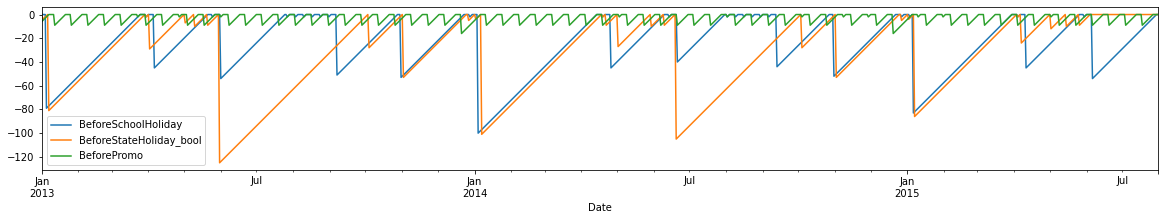

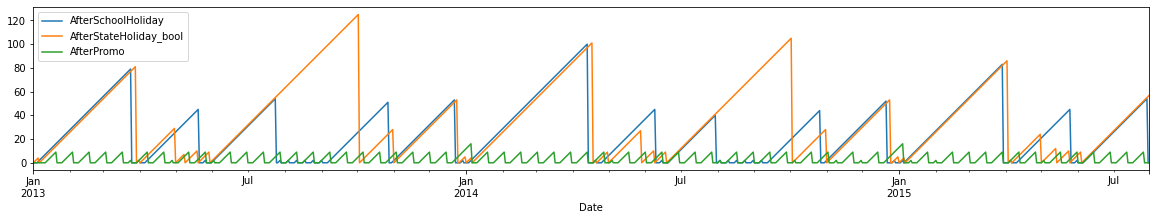

In [101]:
plt.figure(figsize=(20,3))
df_train[df_train['Store'] == 280]['BeforeSchoolHoliday'].plot()
df_train[df_train['Store'] == 280]['BeforeStateHoliday_bool'].plot()
df_train[df_train['Store'] == 280]['BeforePromo'].plot()
plt.legend()
plt.show()

plt.figure(figsize=(20,3))
df_train[df_train['Store'] == 280]['AfterSchoolHoliday'].plot()
df_train[df_train['Store'] == 280]['AfterStateHoliday_bool'].plot()
df_train[df_train['Store'] == 280]['AfterPromo'].plot()
plt.legend()
plt.show()

## 10.  "Suavizado" de columnas temporales 

In [102]:
# Datos del store 1 ordenados por fecha
df_train[df_train[['Store']+columns]['Store'] == 1].sort_values('Date').head(20)

,Store,Promo,StateHoliday_bool,SchoolHoliday,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday_bool,BeforeStateHoliday_bool,AfterPromo,BeforePromo
Date,,,,,,,,,,
2013-01-01,1,0,True,1,0,0,0,0,0,-6
2013-01-02,1,0,False,1,0,0,1,-86,0,-5
2013-01-03,1,0,False,1,0,0,2,-85,0,-4
2013-01-04,1,0,False,1,0,0,3,-84,0,-3
2013-01-05,1,0,False,1,0,0,4,-83,0,-2
2013-01-06,1,0,False,1,0,0,5,-82,0,-1
2013-01-07,1,1,False,1,0,0,6,-81,0,0
2013-01-08,1,1,False,1,0,0,7,-80,0,0
2013-01-09,1,1,False,1,0,0,8,-79,0,0


**Suma semanal backward**: 
Vamos a realizar el suavizado de las columnas de eventos usando ventanas móviles de tamaño 7 (fechas). Lo hacemos para cada tienda. Para cada fecha, la ventana agarra los últimos 6 días (más la fecha sobre la que está posicionada) y suma los 7 valores. Por eso la llamamos suma semanal backward (bwd).

In [103]:
bwd_train = df_train[['Store']+columns].sort_index().groupby("Store").rolling(7, min_periods=1).sum()
bwd_test = df_test[['Store']+columns].sort_index().groupby("Store").rolling(7, min_periods=1).sum()
bwd_train.head(30)

SchoolHoliday  StateHoliday_bool  Promo
Store Date                                               
1     2013-01-01            1.0                1.0    0.0
      2013-01-02            2.0                1.0    0.0
      2013-01-03            3.0                1.0    0.0
      2013-01-04            4.0                1.0    0.0
      2013-01-05            5.0                1.0    0.0
      2013-01-06            6.0                1.0    0.0
      2013-01-07            7.0                1.0    1.0
      2013-01-08            7.0                0.0    2.0
      2013-01-09            7.0                0.0    3.0
      2013-01-10            7.0                0.0    4.0
      2013-01-11            7.0                0.0    5.0
      2013-01-12            6.0                0.0    5.0
      2013-01-13            5.0                0.0    5.0
      2013-01-14            4.0                0.0    4.0
      2013-01-15            3.0                0.0    3.0
      2013-01-16            2.0                0.0    2.0
      2013-01-17            1.0                0.0    1.0
      2013-01-18            0.0                0.0    0.0
      2013-01-19            0.0                0.0    0.0
      2013-01-20            0.0                0.0    0.0
      2013-01-21            0.0                0.0    1.0
      2013-01-22            0.0                0.0    2.0
      2013-01-23            0.0                0.0    3.0
      2013-01-24            0.0                0.0    4.0
      2013-01-25            0.0                0.0    5.0
      2013-01-26            0.0                0.0    5.0
      2013-01-27            0.0                0.0    5.0
      2013-01-28            0.0                0.0    4.0
      2013-01-29            0.0                0.0    3.0
      2013-01-30            0.0                0.0    2.0

Volvemos a poner Store como columna

In [109]:
bwd_train.reset_index(inplace=True)
bwd_test.reset_index(inplace=True)

In [110]:
bwd_train.head(20)

,Store,Date,SchoolHoliday,StateHoliday_bool,Promo
0,1,2013-01-01,1.0,1.0,0.0
1,1,2013-01-02,2.0,1.0,0.0
2,1,2013-01-03,3.0,1.0,0.0
3,1,2013-01-04,4.0,1.0,0.0
4,1,2013-01-05,5.0,1.0,0.0
5,1,2013-01-06,6.0,1.0,0.0
6,1,2013-01-07,7.0,1.0,1.0
7,1,2013-01-08,7.0,0.0,2.0
8,1,2013-01-09,7.0,0.0,3.0
9,1,2013-01-10,7.0,0.0,4.0


**Suma semanal forward**: Ahora ordenamos las fechas al revés y repetimos la suma por ventanas y de esta forma tendremos la suma semanal forward que incluye el valor de la fecha actual más los de los 6 días posteriores.

In [112]:
# Ordena al revés
fwd_train = df_train[['Store']+columns].sort_index(ascending=False).groupby("Store").rolling(7, min_periods=1).sum()
fwd_test = df_test[['Store']+columns].sort_index(ascending=False).groupby("Store").rolling(7, min_periods=1).sum()

In [113]:
fwd_train.head(20)

SchoolHoliday  StateHoliday_bool  Promo
Store Date                                               
1     2015-07-31            1.0                0.0    1.0
      2015-07-30            2.0                0.0    2.0
      2015-07-29            3.0                0.0    3.0
      2015-07-28            4.0                0.0    4.0
      2015-07-27            5.0                0.0    5.0
      2015-07-26            5.0                0.0    5.0
      2015-07-25            5.0                0.0    5.0
      2015-07-24            4.0                0.0    4.0
      2015-07-23            3.0                0.0    3.0
      2015-07-22            2.0                0.0    2.0
      2015-07-21            1.0                0.0    1.0
      2015-07-20            0.0                0.0    0.0
      2015-07-19            0.0                0.0    0.0
      2015-07-18            0.0                0.0    0.0
      2015-07-17            0.0                0.0    1.0
      2015-07-16            0.0                0.0    2.0
      2015-07-15            0.0                0.0    3.0
      2015-07-14            0.0                0.0    4.0
      2015-07-13            0.0                0.0    5.0
      2015-07-12            0.0                0.0    5.0

Volvemos a poner a Store como columna.

In [114]:
fwd_train.reset_index(inplace=True)
fwd_test.reset_index(inplace=True)

En df_train y df_test volvemos a poner a Date como columna

In [116]:
df_train.reset_index(inplace=True)
df_test.reset_index(inplace=True)

#### Merge entre las tablas que generamos

Unimos df_train con bwd_train y fwd_train; y df_test con bwd_test y fwd_test. Usamos Date y Store.

In [117]:
df_train = df_train.merge(bwd_train, 'left', ['Date', 'Store'], suffixes=['', '_bw'])
df_train = df_train.merge(fwd_train, 'left', ['Date', 'Store'], suffixes=['', '_fw'])
df_test = df_test.merge(bwd_test, 'left', ['Date', 'Store'], suffixes=['', '_bw'])
df_test = df_test.merge(fwd_test, 'left', ['Date', 'Store'], suffixes=['', '_fw'])

Eliminamos las columnas que usamos para los cálculos porque ya las tenemos en los df joined.

In [62]:
df_train.drop(columns,1,inplace=True)
df_test.drop(columns,1,inplace=True)

In [121]:
df_train.head()

,Date,Store,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday_bool,BeforeStateHoliday_bool,AfterPromo,BeforePromo,SchoolHoliday_bw,StateHoliday_bool_bw,Promo_bw,SchoolHoliday_fw,StateHoliday_bool_fw,Promo_fw
0,2015-07-31,1,0,0,57,0,0,0,5.0,0.0,5.0,1.0,0.0,1.0
1,2015-07-30,1,0,0,56,0,0,0,4.0,0.0,4.0,2.0,0.0,2.0
2,2015-07-29,1,0,0,55,0,0,0,3.0,0.0,3.0,3.0,0.0,3.0
3,2015-07-28,1,0,0,54,0,0,0,2.0,0.0,2.0,4.0,0.0,4.0
4,2015-07-27,1,0,0,53,0,0,0,1.0,0.0,1.0,5.0,0.0,5.0


Pasamos a fecha la columna Date

In [122]:
df_train["Date"] = pd.to_datetime(df_train.Date)
df_test["Date"] = pd.to_datetime(df_test.Date)

## 10. Merge con el dataframe 'joined'

Hacemos un join de los sub-dataframes de las duraciones con el dataframe completo (joined_train y joined_test). Usamos como columnas de unión Store y Date.

In [128]:
joined_train = join_df(joined_train, df_train, ['Store', 'Date'])
joined_test = join_df(joined_test, df_test, ['Store', 'Date'])

In [129]:
joined_train.shape

(1017209, 81)

Vemos cómo quedo finalmente el dataframe con los datos preprocesados.

In [135]:
joined_train

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,...,AfterStateHoliday_bool,BeforeStateHoliday_bool,AfterPromo,BeforePromo,SchoolHoliday_bw,StateHoliday_bool_bw,Promo_bw,SchoolHoliday_fw,StateHoliday_bool_fw,Promo_fw
0,1,5,2015-07-31,5263,555,1,1,0,1,2015,...,57,0,0,0,5.0,0.0,5.0,1.0,0.0,1.0
1,2,5,2015-07-31,6064,625,1,1,0,1,2015,...,67,0,0,0,5.0,0.0,5.0,1.0,0.0,1.0
2,3,5,2015-07-31,8314,821,1,1,0,1,2015,...,57,0,0,0,5.0,0.0,5.0,1.0,0.0,1.0
3,4,5,2015-07-31,13995,1498,1,1,0,1,2015,...,67,0,0,0,5.0,0.0,5.0,1.0,0.0,1.0
4,5,5,2015-07-31,4822,559,1,1,0,1,2015,...,57,0,0,0,5.0,0.0,5.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,2013,...,0,0,0,-6,1.0,1.0,0.0,4.0,1.0,1.0
1017205,1112,2,2013-01-01,0,0,0,0,a,1,2013,...,0,0,0,-6,1.0,1.0,0.0,4.0,1.0,1.0
1017206,1113,2,2013-01-01,0,0,0,0,a,1,2013,...,0,0,0,-6,1.0,1.0,0.0,4.0,1.0,1.0
1017207,1114,2,2013-01-01,0,0,0,0,a,1,2013,...,0,0,0,-6,1.0,1.0,0.0,4.0,1.0,1.0


## 11. Guardamos los dataframes

Guardamos los df preprocesados como .fth

In [133]:
joined_train.to_feather('all_preprocessed_train.fth')

In [134]:
joined_test.to_feather('all_preprocessed_test.fth')

Vemos graficado el resultado del suavizado de las columnas de eventos para un período de fechas en la tienda 280.

## 12. Gráfico del suavizado

Text(0.5, 1.0, 'Promo')

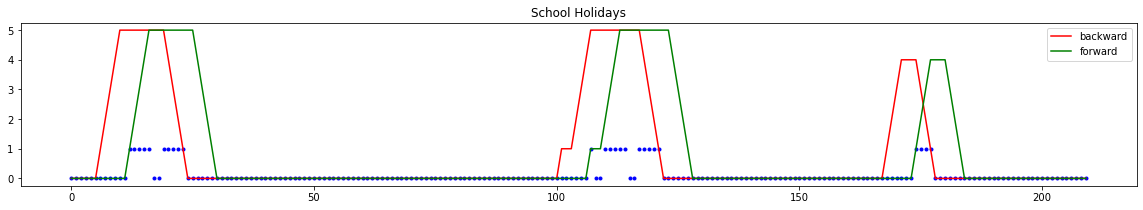

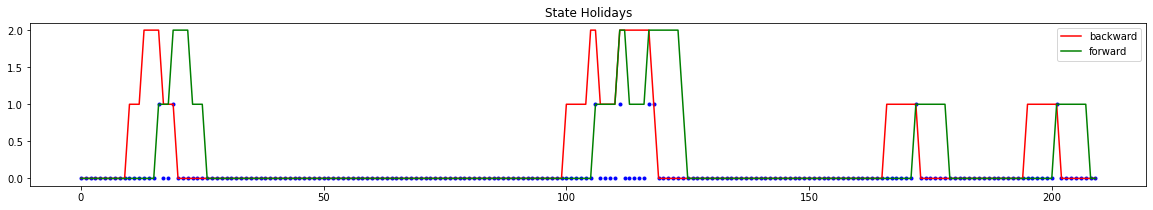

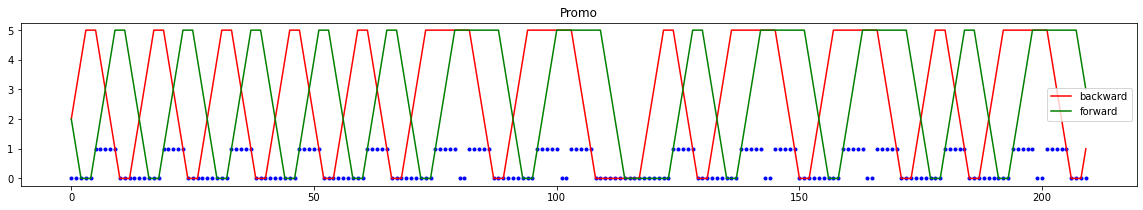

In [132]:
plt.figure(figsize=(20,3))
plt.plot(joined_train[joined_train['Store']==280]['SchoolHoliday'].values[100:310]*1.0, c='b', marker='.', linestyle='None')
plt.plot(joined_train[joined_train['Store']==280]['SchoolHoliday_bw'].values[100:310]*1.0, c='r', label='backward')
plt.plot(joined_train[joined_train['Store']==280]['SchoolHoliday_fw'].values[100:310]*1.0, c='g', label='forward')
plt.legend()
plt.title('School Holidays')
plt.figure(figsize=(20,3))
plt.plot(joined_train[joined_train['Store']==280]['StateHoliday_bool'].values[100:310]*1.0, c='b', marker='.', linestyle='None')
plt.plot(joined_train[joined_train['Store']==280]['StateHoliday_bool_bw'].values[100:310]*1.0, c='r', label='backward')
plt.plot(joined_train[joined_train['Store']==280]['StateHoliday_bool_fw'].values[100:310]*1.0, c='g', label='forward')
plt.legend()
plt.title('State Holidays')
plt.figure(figsize=(20,3))
plt.plot(joined_train[joined_train['Store']==280]['Promo'].values[100:310]*1.0, c='b', marker='.', linestyle='None')
plt.plot(joined_train[joined_train['Store']==280]['Promo_bw'].values[100:310]*1.0, c='r', label='backward')
plt.plot(joined_train[joined_train['Store']==280]['Promo_fw'].values[100:310]*1.0, c='g', label='forward')
plt.legend()
plt.title('Promo')